In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

## K100 data

In [2]:
BC = pd.read_csv('BC_32ea_k15_cyto.csv')
Normal = pd.read_csv('Normal_21ea_k15_cyto.csv')
PC = pd.read_csv('PC_20ea_k15_cyto.csv')
# RC_100 = pd.read_csv('RC_20ea_k100_cyto.csv')

In [3]:
#drop person id
BC.drop(['Unnamed: 0','id'], axis = 1, inplace = True)
Normal.drop(['Unnamed: 0','id'], axis = 1, inplace = True)
PC.drop(['Unnamed: 0','id'], axis = 1, inplace = True)
# RC_100.drop(['Unnamed: 0','id'], axis = 1, inplace = True)

In [4]:
BC['cancer'] = 'BC'
Normal['cancer'] = 'normal'
PC['cancer'] = 'PC'
# RC_100['cancer'] = "RC"

K15 = pd.concat([BC,Normal,PC], axis = 0)

In [5]:
del [BC,Normal,PC]

In [6]:
K15.shape

(73, 769)

In [7]:
K15.cancer.value_counts()

BC        32
normal    21
PC        20
Name: cancer, dtype: int64

In [8]:
K15.isna().sum().sum()

127

In [9]:
K15_drop = K15.dropna(axis=0)

In [10]:
K15_drop.isna().sum().sum()

0

In [11]:
K15_drop.cancer.value_counts()

BC        32
normal    21
PC        19
Name: cancer, dtype: int64

In [12]:
print(K15.shape)
print(K15_drop.shape)

(73, 769)
(72, 769)


In [13]:
K15_drop.head()

,cyto.10p11.1,cyto.10p11.21,cyto.10p11.22,cyto.10p11.23,cyto.10p12.1,cyto.10p12.2,cyto.10p12.31,cyto.10p12.32,cyto.10p12.33,cyto.10p13,...,cyto.9q33.1,cyto.9q33.2,cyto.9q33.3,cyto.9q34.11,cyto.9q34.12,cyto.9q34.13,cyto.9q34.2,cyto.9q34.3,<NA>,cancer
0,-0.011625,-0.032886,0.006310,-0.06082,-0.014478,-0.033118,0.013153,0.132667,-0.060415,-0.013423,...,-0.030410,-0.083477,-0.043708,-0.022850,-0.041424,-0.040248,-0.056494,-0.041278,-0.015901,BC
1,-0.063208,-0.039772,-0.061178,-0.04797,-0.014949,-0.047236,0.018109,-0.246500,-0.037925,0.012408,...,-0.119689,-0.116231,-0.078664,-0.099285,-0.091061,-0.115920,-0.034854,-0.050695,-0.123485,BC
2,0.163167,-0.073174,-0.072665,0.03516,-0.107599,-0.034165,-0.118194,0.001167,0.019811,-0.092081,...,-0.252597,-0.289352,-0.146678,-0.166425,-0.068879,-0.164168,-0.169764,-0.233489,-0.062123,BC
3,-0.088125,-0.034087,-0.134503,-0.18650,-0.017468,-0.100008,-0.079250,0.019667,0.108453,-0.099898,...,-0.100810,-0.089949,-0.095227,-0.052330,-0.044576,-0.075440,-0.080101,-0.035848,-0.091942,BC
4,-0.420667,-0.239274,-0.271827,-0.22751,-0.242785,-0.206063,-0.186331,-0.113333,-0.279679,-0.100538,...,-0.173568,-0.071681,-0.009905,-0.051725,-0.001879,-0.016784,-0.023449,-0.047915,-0.115848,BC


## 1.1 Classification : KNN 

In [14]:
#대대분류 삭제
K15_cluter = K15_drop.drop('cancer', axis = 1)
K15_cluter.shape

(72, 768)

In [15]:
mms = MinMaxScaler()
mms.fit(K15_cluter) #대대분류 뺀 column들만 갖고
cluster_transformed = mms.transform(K15_cluter)

In [16]:
# original 
k=3
km = KMeans(n_clusters = k, algorithm = 'auto')
km.fit(K15_cluter) # 데이터를 이용하여 클러스터링을 위한 학습 시작하고 중심점 추출
km_predict = pd.DataFrame(km.predict(K15_cluter)) # 학습된 모델이 맞춰 라벨 리턴
km_predict.columns = ['predict']
km_predict.predict.value_counts()

0    65
1     6
2     1
Name: predict, dtype: int64

In [17]:
# scale data
km = KMeans(n_clusters = k, algorithm = 'auto')
km.fit(cluster_transformed) # 데이터를 이용하여 클러스터링을 위한 학습 시작하고 중심점 추출
km_predict_scale = pd.DataFrame(km.predict(cluster_transformed)) # 학습된 모델이 맞춰 라벨 리턴
km_predict_scale.columns = ['predict']
km_predict_scale.predict.value_counts()

1    61
0     9
2     2
Name: predict, dtype: int64

## 1.2 Classification : Modeling

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier()
from sklearn.svm import SVC
svm1 = SVC()

C:\ProgramData\Anaconda1\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [19]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
cv = KFold(5, shuffle=True, random_state=0)

In [20]:
for i, (idx_train, idx_cv) in enumerate(cv.split(K15_drop)):
    df_train = K15_drop.iloc[idx_train]
    df_cv = K15_drop.iloc[idx_cv]
    
    x_train = df_train.drop(['cancer'], axis=1)
    y_train = df_train['cancer']
    
    x_cv = df_cv.drop(['cancer'], axis=1)
    y_cv = df_cv['cancer']
    
    print('[   K =',i,'   ]')
    print('-----------svm-----------')
    svm1.fit(x_train, y_train)
    print("train accurcacy = {}, cv accurcacy = {}".format(accuracy_score(y_train, svm1.predict(x_train)), accuracy_score(y_cv, svm1.predict(x_cv))))
    
    print('--------rf--------')
    rf1.fit(x_train, y_train)
    print("train accurcacy = {}, cv accurcacy = {}".format(accuracy_score(y_train, rf1.predict(x_train)), accuracy_score(y_cv, rf1.predict(x_cv))))
    

[   K = 0    ]
-----------svm-----------
train accurcacy = 0.43859649122807015, cv accurcacy = 0.4666666666666667
--------rf--------
train accurcacy = 1.0, cv accurcacy = 0.6
[   K = 1    ]
-----------svm-----------
train accurcacy = 0.47368421052631576, cv accurcacy = 0.3333333333333333
--------rf--------
train accurcacy = 1.0, cv accurcacy = 0.4666666666666667
[   K = 2    ]
-----------svm-----------
train accurcacy = 0.43103448275862066, cv accurcacy = 0.5
--------rf--------
train accurcacy = 1.0, cv accurcacy = 0.5714285714285714
[   K = 3    ]
-----------svm-----------
train accurcacy = 0.43103448275862066, cv accurcacy = 0.5
--------rf--------
train accurcacy = 0.9827586206896551, cv accurcacy = 0.5714285714285714
[   K = 4    ]
-----------svm-----------
train accurcacy = 0.4482758620689655, cv accurcacy = 0.42857142857142855
--------rf--------
train accurcacy = 0.9827586206896551, cv accurcacy = 0.5


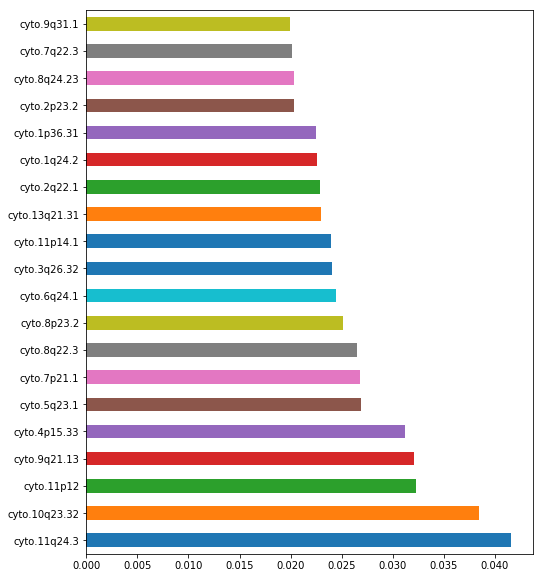

In [24]:
plt.figure(figsize=(8,10))

feat_importances = pd.Series(rf1.feature_importances_, index=x_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [47]:
feat_importances.sort_values(ascending=False)

cyto.18q21.32    0.065800
cyto.4q35.2      0.042415
cyto.8q21.2      0.034966
cyto.17p13.3     0.033759
cyto.3p25.2      0.032841
cyto.5q31.3      0.032310
cyto.8q22.1      0.028372
cyto.5q23.1      0.026430
cyto.12q23.3     0.025581
cyto.9p21.3      0.024227
cyto.10q23.1     0.023772
cyto.2q37.3      0.022810
cyto.13q12.13    0.022578
cyto.5q22.3      0.021458
cyto.12p13.33    0.019755
cyto.4p15.31     0.019264
cyto.7q36.2      0.019225
cyto.10q26.3     0.019031
cyto.1q22        0.018140
cyto.3q27.1      0.017388
cyto.2q22.1      0.017216
cyto.8q22.2      0.017181
cyto.10q25.2     0.015453
cyto.10q22.2     0.015363
cyto.15q13.1     0.015242
cyto.4q21.23     0.014892
cyto.12q14.1     0.013889
cyto.14q32.11    0.012664
cyto.14q24.2     0.012587
cyto.13q34       0.012475
                   ...   
cyto.3p25.3      0.000000
cyto.3p25.1      0.000000
cyto.3p24.3      0.000000
cyto.3p24.2      0.000000
cyto.3p24.1      0.000000
cyto.3p23        0.000000
cyto.3p22.3      0.000000
cyto.3q13.31